In [1]:
%matplotlib inline
%matplotlib widget
import pandas as pd
import numpy as np
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from ipywidgets import interact
import ipywidgets as widgets

from mpl_toolkits.axes_grid1 import make_axes_locatable

import geopandas as gpd
from shapely import wkt
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)


new_cases_df = pd.read_csv("Assignment 2_datasets\Assignment 2_datasets/1.COVID-19_daily_number_of_new_cases_and_deaths.csv", sep=",")
vaccination_df = pd.read_csv("Assignment 2_datasets/Assignment 2_datasets/2.COVID-19_vaccination.csv", sep=",")
icu_df = pd.read_csv("Assignment 2_datasets\Assignment 2_datasets/3.COVID-19_hospital_and_ICU_admission_rates.csv", sep=",")

#little formating script to format 1000000 to 1,000,000
def format_with_thousand_sep(x, pos):
        return "{:,.0f}".format(x)

# Cleaning process new_cases_df
- get rid of unessesary data
- drop duplicates
- missing values
    - Checked for NaN rows in each column individually
    - cases and deaths are the only columns with missing values in new_case_df
- check that colunms are consistent/formating
- outliers
    Due to some contries compenstaing for reporting to high with negative values another day we can't detect outliers.



In [2]:
display(new_cases_df)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,23/10/2022,23,10,2022,3557.0,0.0,Austria,AT,AUT,8901064,Europe
1,22/10/2022,22,10,2022,5494.0,4.0,Austria,AT,AUT,8901064,Europe
2,21/10/2022,21,10,2022,7776.0,4.0,Austria,AT,AUT,8901064,Europe
3,20/10/2022,20,10,2022,8221.0,6.0,Austria,AT,AUT,8901064,Europe
4,19/10/2022,19,10,2022,10007.0,8.0,Austria,AT,AUT,8901064,Europe
...,...,...,...,...,...,...,...,...,...,...,...
28724,08/02/2020,8,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
28725,07/02/2020,7,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
28726,06/02/2020,6,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
28727,05/02/2020,5,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe


In [3]:
new_cases_df = new_cases_df.loc[new_cases_df["countriesAndTerritories"] != "Liechtenstein"]


new_cases_df.drop_duplicates()

def repair_by_month(column):
    grouped_df = new_cases_df.groupby(['countriesAndTerritories','year','month']) #group by month, year and country
    for name,group in grouped_df: #for each group
        country = name[0] #get month
        year = name[1] #get year
        month = name[2] #get country

        try:
            moast_frequent = group[column].value_counts().idxmax() #get the most frequent value
        except ValueError:
            print(country,month,year) #print the country, month and year of the error
            moast_frequent = 0 #set the most frequent value to 0
        new_cases_df.loc[(new_cases_df['countriesAndTerritories'] == country) & (new_cases_df['month'] == month) & (new_cases_df['year'] == year), column] = new_cases_df.loc[(new_cases_df['countriesAndTerritories'] == country) & (new_cases_df['month'] == month) & (new_cases_df['year'] == year), column].fillna(moast_frequent)

repair_by_month("deaths") #repair the deaths column
repair_by_month("cases") #repair the cases column


Iceland 2 2020
Norway 2 2020


In [4]:
def repair_dates_formatting():
    for index,row in new_cases_df.iterrows():
        new_cases_df.loc[index, "dateRep"] = datetime.datetime(new_cases_df.loc[index, "year"], new_cases_df.loc[index, "month"], new_cases_df.loc[index, "day"]).date()
repair_dates_formatting()

#### Formating columns with floats to int

In [5]:
new_cases_df['cases'] = new_cases_df['cases'].astype(int)
new_cases_df['deaths'] = new_cases_df['deaths'].astype(int)
new_cases_df["dateRep"] = pd.to_datetime(new_cases_df["dateRep"],infer_datetime_format=True) #convert dateRep to datetime

# Now you can use the modified 'cases' and 'deaths' columns in the original DataFrame
new_cases_df.loc[:, ['cases', 'deaths']] = new_cases_df[['cases', 'deaths']].values.copy()

# Verify the updated DataFrame
display(new_cases_df)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,2022-10-23,23,10,2022,3557,0,Austria,AT,AUT,8901064,Europe
1,2022-10-22,22,10,2022,5494,4,Austria,AT,AUT,8901064,Europe
2,2022-10-21,21,10,2022,7776,4,Austria,AT,AUT,8901064,Europe
3,2022-10-20,20,10,2022,8221,6,Austria,AT,AUT,8901064,Europe
4,2022-10-19,19,10,2022,10007,8,Austria,AT,AUT,8901064,Europe
...,...,...,...,...,...,...,...,...,...,...,...
28724,2020-02-08,8,2,2020,0,0,Sweden,SE,SWE,10327589,Europe
28725,2020-02-07,7,2,2020,0,0,Sweden,SE,SWE,10327589,Europe
28726,2020-02-06,6,2,2020,0,0,Sweden,SE,SWE,10327589,Europe
28727,2020-02-05,5,2,2020,0,0,Sweden,SE,SWE,10327589,Europe


### From the block below we can see that there are no outliars in the popData2020 column because there's only one unique value for each country.

In [6]:
import scipy.stats as st

# Gets all unique values for the population by country
population_per_country = new_cases_df.groupby("countriesAndTerritories")["popData2020"].unique()

population_per_country

countriesAndTerritories
Austria         [8901064]
Belgium        [11522440]
Bulgaria        [6951482]
Croatia         [4058165]
Cyprus           [888005]
Czechia        [10693939]
Denmark         [5822763]
Estonia         [1328976]
Finland         [5525292]
France         [67320216]
Germany        [83166711]
Greece         [10718565]
Hungary         [9769526]
Iceland          [364134]
Ireland         [4964440]
Italy          [59641488]
Latvia          [1907675]
Lithuania       [2794090]
Luxembourg       [626108]
Malta            [514564]
Netherlands    [17407585]
Norway          [5367580]
Poland         [37958138]
Portugal       [10295909]
Romania        [19328838]
Slovakia        [5457873]
Slovenia        [2095861]
Spain          [47332614]
Sweden         [10327589]
Name: popData2020, dtype: object

In [7]:

grouped_df = new_cases_df.groupby(['countriesAndTerritories','year', 'month'])

is_normal = True

for info, groupby in grouped_df:
    country = info[0] #get country
    year = info[1] #get year
    month = info[2] #get month

    groupby = groupby.loc[(groupby['countriesAndTerritories'] == country) & (groupby['month'] == month) & (groupby['year'] == year)]

    # print(country, month, year)
    if len(groupby['deaths']) > 3:
            if groupby['deaths'].nunique() > 1:  # Check for non-zero range
                stat, p_value = st.shapiro(groupby['deaths'])
                if p_value < 0.05:
                    is_normal = False
                    print(f"Data for {country} is not normal")
            else:
                is_normal = False
                print(f"Data for {country} has zero range")
    else:
        print("Not enough data")

print(f"There is normal distribution: {is_normal}")




Data for Austria has zero range
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Bulgaria is not normal
Data for Bulgaria is not normal
Data 

# Cleaning  COVID-19 vaccinations Dataset

46% missing data in denominator column, and because the questions doen't require comperasions agains specific age-groups we decided to remove it alltogether

In [8]:
missingvalues = vaccination_df["FirstDoseRefused"].isna().sum()/len(vaccination_df["FirstDoseRefused"])
print(f"Percentage of missing values in FirstDoseRefused: {round(missingvalues,4)*100}%")

missingvaluesdenominator = vaccination_df["Denominator"].isna().sum()/len(vaccination_df["Denominator"])
print(f"Percentage of missing values in Denominator: {round(missingvaluesdenominator,4)*100}%")

Percentage of missing values in FirstDoseRefused: 99.79%
Percentage of missing values in Denominator: 46.93%


In [9]:
vaccination_df.drop_duplicates()
vaccination_df["NumberDosesReceived"] = vaccination_df["NumberDosesReceived"].fillna(0) #fill the missing values with 0
vaccination_df["NumberDosesExported"] = vaccination_df["NumberDosesExported"].fillna(0) #fill the missing values with 0
vaccination_df.drop(columns=['FirstDoseRefused'], inplace=True) #removes the column since it has 99.78762127016277% missing values
vaccination_df.drop(columns=['Denominator'], inplace=True)  #removes the column since it has 46.934525119985906% missing values
vaccination_df["YearWeekISO"] = pd.to_datetime(vaccination_df["YearWeekISO"] + "-1", format="%Y-W%W-%w")

print(vaccination_df.isna().sum())

YearWeekISO            0
ReportingCountry       0
NumberDosesReceived    0
NumberDosesExported    0
FirstDose              0
SecondDose             0
DoseAdditional1        0
DoseAdditional2        0
DoseAdditional3        0
DoseAdditional4        0
DoseAdditional5        0
UnknownDose            0
Region                 0
TargetGroup            0
Vaccine                0
Population             0
dtype: int64


## Cleaning 3rd dataset
Theres no values in the url column, therefore we'll remove it completly

In [10]:
icu_df = icu_df.drop_duplicates()
icu_df = icu_df.drop(columns=['url'], axis=1)
icu_df = icu_df.drop(columns=['source'], axis=1)
icu_df["year_week"] = pd.to_datetime(icu_df["year_week"] + "-1", format="%Y-W%W-%w")
icu_df.isna().sum()  


country      0
indicator    0
date         0
year_week    0
value        0
dtype: int64

In [11]:
icu_df["date"] = pd.to_datetime(icu_df["date"], format="%Y-%m-%d")

In [12]:
icu_df.groupby(["indicator"]).count() #Daily metric is most common indicator, therefore we will convert all other indicators to daily metric

,country,date,year_week,value
indicator,,,,
Daily ICU occupancy,8842,8842,8842,8842
Daily hospital occupancy,10984,10984,10984,10984
Weekly new ICU admissions per 100k,2358,2358,2358,2358
Weekly new hospital admissions per 100k,2916,2916,2916,2916


Extracts weekly data from indicator and value columns and then converts it to daily data by dividing by 7 and changing the indicator name

# Questions:

# Q1: 
Since 2020 till 2022, which top-10 countries reported the most number of cases of COVID-19 in quarters per year (Q1-Q4 in each year)? Do you find these numbers relatively high compared to the country’s population? Do you see any connection among these countries regarding their geographical locations and the period that most cases are observed? Discuss your observations

Observation:  
There are moastly big countries in central Europe that are in the top 10 list each quarter. These countries also often have adjacent borders to eachother. This shows that adjecent countries could pass the covid-19 virus between them when people are traveling betweene countries. We can also see that in the begining of 2022 when many countries lifted thire restrictions the covid spiked like never before and countries got up to 40% of thire population sick (Denmark).

In [29]:
#Adding a column with the quarter
new_cases_df["Period"] = new_cases_df["dateRep"].dt.to_period('Q')

#groupping by quarter and country and summing cases and takingt the population of the first row since it's allway the same
new_cases_grouped_Q = new_cases_df.groupby("Period").apply(lambda x: x.groupby("countriesAndTerritories").agg({"cases": "sum", "popData2020": "first"}).sort_values("cases", ascending=False).head(10))

#Calculate the percentage of cases per country
new_cases_grouped_Q["Percentage"] = round((new_cases_grouped_Q["cases"]/new_cases_grouped_Q["popData2020"])*100,3)


new_cases_grouped_Q = new_cases_grouped_Q.reset_index() #reset the index

In [34]:

#Loading in the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[(world.continent == 'Europe')] #filter out europe to only use it for the map
filtered_europe = europe[~europe.name.isin(['Russia'])] #remove Russia since it is not in the dataset

#Removing France overseas terretories by editiing the polygons
geometry = wkt.loads('MULTIPOLYGON (((6.186320428094177 49.463802802114515, 6.658229607783568 49.20195831969157, 8.099278598674744 49.01778351500333, 7.593676385131062 48.33301911070372, 7.466759067422231 47.62058197691181, 7.192202182655507 47.44976552997102, 6.736571079138059 47.541801255882845, 6.768713820023606 47.2877082383037, 6.037388950229001 46.725778713561866, 6.022609490593538 46.27298981382047, 6.5000997249704255 46.42967275652944, 6.843592970414505 45.99114655210061, 6.802355177445605 45.70857982032864, 7.096652459347837 45.33309886329589, 6.749955275101655 45.02851797136758, 7.007562290076635 44.25476675066136, 7.549596388386107 44.12790110938481, 7.435184767291872 43.69384491634922, 6.52924523278304 43.128892320318315, 4.556962517931424 43.399650987311595, 3.1004105973526634 43.075200507167054, 2.9859989762584576 42.47301504166986, 1.8267932470871528 42.34338471126569, 0.7015906103638941 42.795734361332606, 0.3380469091905809 42.57954600683955, -1.502770961910528 43.03401439063043, -1.901351284177764 43.42280202897834, -1.384225226232985 44.022610378590116, -1.1937975732374184 46.01491771095486, -2.2257242496738456 47.06436269793822, -2.9632761295596026 47.57032664650795, -4.4915549381594815 47.954954332056374, -4.592349819344776 48.68416046812699, -3.295813971357802 48.90169240985963, -1.6165107893849608 48.64442129169454, -1.933494025063311 49.776341864615745, -0.98946895995536 49.34737580016091, 1.3387610205226963 50.12717316344526, 1.6390010921384996 50.9466063502975, 2.5135730322461427 51.14850617126183, 2.658422071960274 50.796848049515745, 3.1232515804256877 50.78036326761455, 3.588184441755658 50.37899241800356, 4.2860229834250845 49.907496649772554, 4.799221632515724 49.98537303323637, 5.674051954784829 49.529483547557504, 5.897759230176348 49.44266714130711, 6.186320428094177 49.463802802114515)), ((8.746009148807559 42.62812185319392, 9.390000848028876 43.00998484961471, 9.560016310269134 42.15249197037952, 9.229752231491773 41.380006822264455, 8.775723097375362 41.58361196549443, 8.544212680707773 42.25651662858306, 8.746009148807559 42.62812185319392)))')
filtered_europe.loc[filtered_europe["name"] == "France", "geometry"] = geometry

#Creating a colormap for to apply on the map
color_palette = cm.get_cmap('YlOrBr')
norm = Normalize(vmin=0, vmax=40)

#Function that clears the plot
def erase_plot():
    ax.clear()

#Function that plots the map with the top 10 countries with the most cases
def cases_map(x):
    ax = None

    if ax is not None:
        erase_plot()

    #Take the top 10 countries with the most cases, this is done with index since the dataframe is allready sordet by cases. increasing the speed since we dont have to take out the data every single time
    countries_list = list(new_cases_grouped_Q.iloc[x:(x+10)]["countriesAndTerritories"]) #get the top 10 countries with the most cases
    cases_countries = filtered_europe[filtered_europe['name'].isin(countries_list)]

    #Merge the dataframes to get the percentage of cases in each country
    cases_countries_merged = cases_countries.merge(new_cases_grouped_Q.iloc[x:(x+10)][["countriesAndTerritories","Percentage"]], left_on=["name"], right_on="countriesAndTerritories", how="inner")

    #Getting the countries that are not in the top 10 so even they can be plotted
    ax = filtered_europe.plot(figsize=(8,6),edgecolor='gray', color="White")

    #Giving color to the countries that are in the top 10
    cases_countries_merged.plot(ax=ax, edgecolor='gray', column="Percentage", cmap=color_palette, norm=norm)
    
    #Settign the title and the labels
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    
    #Plotting the colorbar
    sm = ScalarMappable(cmap=color_palette, norm=norm)
    sm.set_array([])  # Set an empty array for the colorbar
    colorbar = plt.colorbar(sm)
    colorbar.set_label("Percentage of cases in a country")
    
    #showing the plot
    plt.show()

#Creating the interacteble dropdown list to allow us to choose what quarter we want to see
interact(cases_map, x=widgets.Dropdown(options=[('2020Q1', 0),('2020Q2', 10),('2020Q3', 20),('2020Q4', 30),('2021Q1', 40),('2021Q2', 50),('2021Q3', 60),('2021Q4', 70),('2022Q1', 80),('2022Q2', 90),('2022Q3', 100),('2022Q4', 110)],description='Quarter:'))


C:\Users\tobbe\AppData\Local\Temp\ipykernel_19560\2379127060.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


interactive(children=(Dropdown(description='Quarter:', options=(('2020Q1', 0), ('2020Q2', 10), ('2020Q3', 20),…

<function __main__.cases_map(x)>

# Q2
Visualize the total number of cases and deaths in each country on a map using their geographical locations in 2020, 2021, and 2022. Discuss your observations.  

Plotting two maps one for cases and one for deaths we can see that in the early years of covid there was more death but less spread. But on later years we can see that even though there is much more cases there is much less death. This could be due to vaccines getting better, this makes covid more of a flu then a deadly pendamic. When this happends more people are allowed outside since covid is less fatal but i return more people get sick with covid-19.

C:\Users\tobbe\AppData\Local\Temp\ipykernel_19560\2459419017.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


interactive(children=(Dropdown(description='Year:', options=(('2020', 2020), ('2021', 2021), ('2022', 2022)), …

<function __main__.cases_deaths_map(year)>

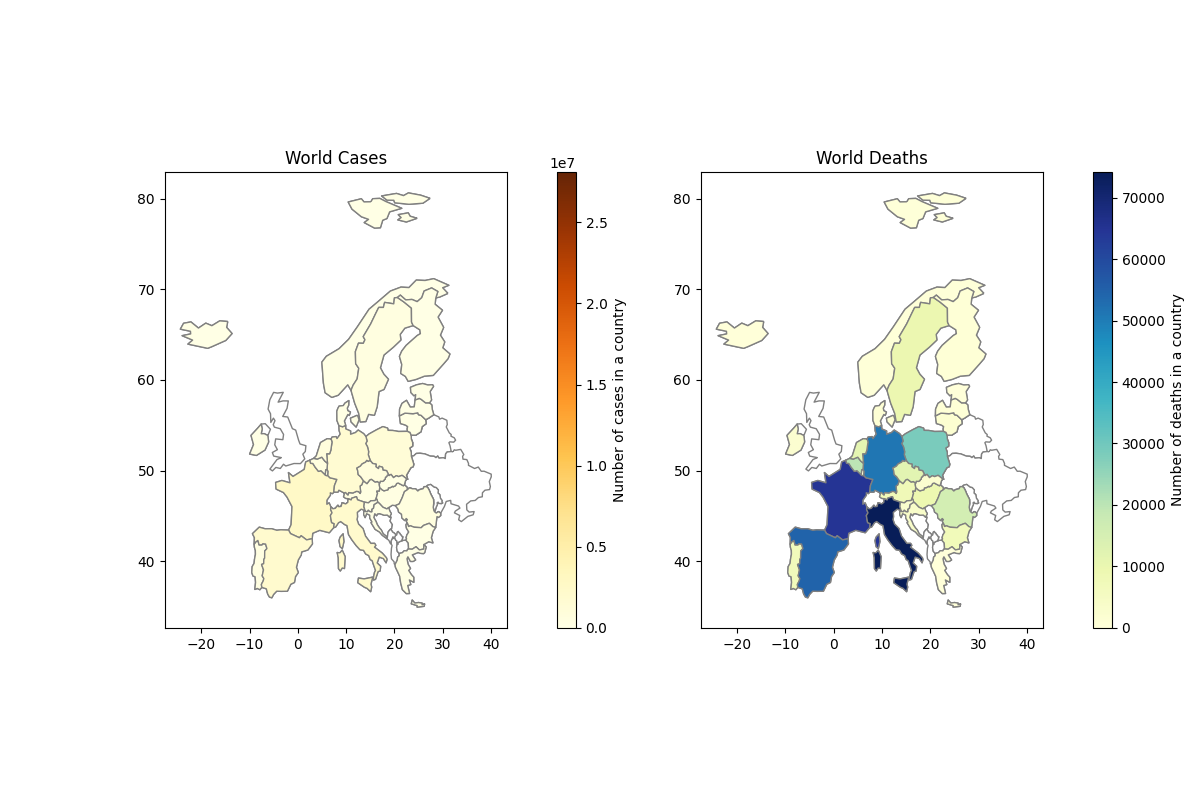

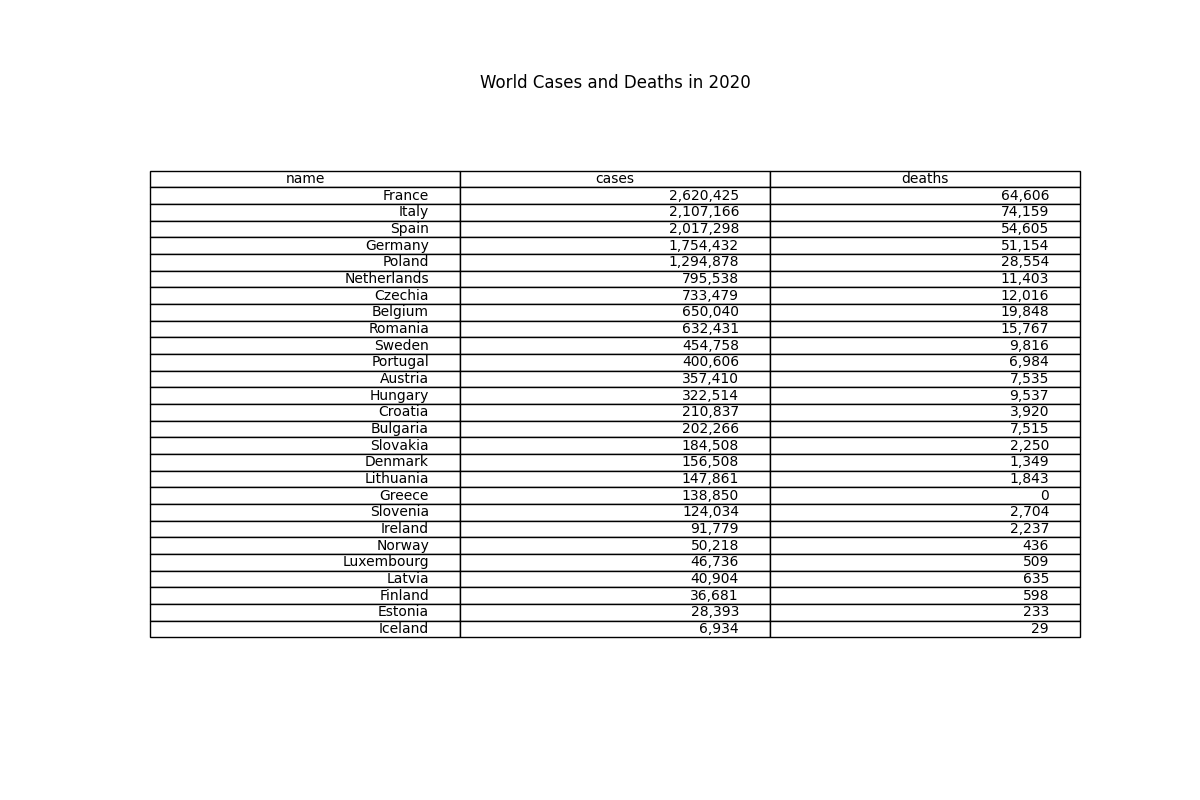

In [74]:
#Groupng data by year and country. Summing up the cases and deaths and taking the population of the first row
new_cases_grouped_Y = new_cases_df.groupby(['year', 'countriesAndTerritories']).agg({"cases": "sum", "deaths": "sum", "popData2020": "first"}).reset_index()

#Loading in teh map and taking only europe, sorting out russia sonce its not in the dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[(world.continent == 'Europe')] 
filtered_europe = europe[~europe.name.isin(['Russia'])]

#Removing France overseas terretories by editiing the polygons
geometry = wkt.loads('MULTIPOLYGON (((6.186320428094177 49.463802802114515, 6.658229607783568 49.20195831969157, 8.099278598674744 49.01778351500333, 7.593676385131062 48.33301911070372, 7.466759067422231 47.62058197691181, 7.192202182655507 47.44976552997102, 6.736571079138059 47.541801255882845, 6.768713820023606 47.2877082383037, 6.037388950229001 46.725778713561866, 6.022609490593538 46.27298981382047, 6.5000997249704255 46.42967275652944, 6.843592970414505 45.99114655210061, 6.802355177445605 45.70857982032864, 7.096652459347837 45.33309886329589, 6.749955275101655 45.02851797136758, 7.007562290076635 44.25476675066136, 7.549596388386107 44.12790110938481, 7.435184767291872 43.69384491634922, 6.52924523278304 43.128892320318315, 4.556962517931424 43.399650987311595, 3.1004105973526634 43.075200507167054, 2.9859989762584576 42.47301504166986, 1.8267932470871528 42.34338471126569, 0.7015906103638941 42.795734361332606, 0.3380469091905809 42.57954600683955, -1.502770961910528 43.03401439063043, -1.901351284177764 43.42280202897834, -1.384225226232985 44.022610378590116, -1.1937975732374184 46.01491771095486, -2.2257242496738456 47.06436269793822, -2.9632761295596026 47.57032664650795, -4.4915549381594815 47.954954332056374, -4.592349819344776 48.68416046812699, -3.295813971357802 48.90169240985963, -1.6165107893849608 48.64442129169454, -1.933494025063311 49.776341864615745, -0.98946895995536 49.34737580016091, 1.3387610205226963 50.12717316344526, 1.6390010921384996 50.9466063502975, 2.5135730322461427 51.14850617126183, 2.658422071960274 50.796848049515745, 3.1232515804256877 50.78036326761455, 3.588184441755658 50.37899241800356, 4.2860229834250845 49.907496649772554, 4.799221632515724 49.98537303323637, 5.674051954784829 49.529483547557504, 5.897759230176348 49.44266714130711, 6.186320428094177 49.463802802114515)), ((8.746009148807559 42.62812185319392, 9.390000848028876 43.00998484961471, 9.560016310269134 42.15249197037952, 9.229752231491773 41.380006822264455, 8.775723097375362 41.58361196549443, 8.544212680707773 42.25651662858306, 8.746009148807559 42.62812185319392)))')
filtered_europe.loc[filtered_europe["name"] == "France", "geometry"] = geometry


#Creating the figures and axes
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
fig_table, ax3 = plt.subplots(figsize=(12,8))

#Setting up deviders to be able to put the colorbar next to the map for both cases and deaths
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='3%', pad=-1)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='3%', pad=-1)

#Making a function to clear the maps when another year is selceted
def erase_plot(year):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax1.set_title("World Cases")
    ax2.set_title("World Deaths")
    ax3.set_title(f"World Cases and Deaths in {year}")

#The main function that creates the plots taking in the year from the interact dropdown
def cases_deaths_map(year):
    erase_plot(year)

    #Filtering the data by selected year and retriving the countries that are in that data set
    filtered_data = new_cases_grouped_Y[new_cases_grouped_Y["year"] == year] 
    countries_list = filtered_data["countriesAndTerritories"].tolist() 
    cases_countries = filtered_europe[filtered_europe['name'].isin(countries_list)]
    cases_countries_merged = cases_countries.merge(filtered_data, left_on="name", right_on="countriesAndTerritories", how="inner")

    ####################################################Plot 1 cases ####################################################
    # Create a color palette and normalizing the colorbar to fit our dataset for cases
    color_palette = cm.get_cmap('YlOrBr') 
    norm = Normalize(vmin=0, vmax=new_cases_grouped_Y["cases"].max())

    # Plot the map for countries that is not in the dataset
    filtered_europe.plot(ax=ax1, edgecolor='gray', color="White")
    #Plotting the countries with relevant color that are in the dataset
    cases_countries_merged.plot(ax=ax1, edgecolor='gray', column="cases", cmap=color_palette, norm=norm, legend=True, cax=cax1) # Plot the data

    #adding the colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=color_palette, norm=norm) 
    sm.set_array([])

    colorbar2 = fig.colorbar(sm, cax=cax1)
    colorbar2.set_label("Number of cases in a country")

    ####################################################Plot 2 deaths ####################################################
    # Create a color palette and normalizing the colorbar to fit our dataset for deaths
    color_palette2 = cm.get_cmap('YlGnBu')
    norm2 = Normalize(vmin=0, vmax=new_cases_grouped_Y["deaths"].max())

    #Plotting the countries with relevant color that are in the dataset
    filtered_europe.plot(ax=ax2, edgecolor='gray', color="White")
    cases_countries_merged.plot(ax=ax2, edgecolor='gray', column="deaths", cmap=color_palette2, norm=norm2, legend=True, cax=cax2)

    #adding the colorbar to the plot
    sm2 = plt.cm.ScalarMappable(cmap=color_palette2, norm=norm2)
    sm2.set_array([])

    colorbar = fig.colorbar(sm2, cax=cax2)
    colorbar.set_label("Number of deaths in a country")


    ####################################################Plot 3 cases and deaths ####################################################
    #Creating a table with the data to display, here are both cases and deaths displayed but the table is sorted after cases
    ax3.axis('off')
    ax3.axis('tight')

    table_content = cases_countries_merged[["name", "cases","deaths"]].sort_values(by="cases", ascending=False).reset_index(drop=True) # Create a dataframe with the data to display sorted on cases
    table_content['cases'] = table_content['cases'].apply(lambda x: format_with_thousand_sep(x, None)) # Format the data
    table_content['deaths'] = table_content['deaths'].apply(lambda x: format_with_thousand_sep(x, None)) # Format the data

    ax3.table(cellText=table_content.values, colLabels=table_content.columns, loc='center')
    fig.tight_layout()

#Setting up a interacteble dropdown to select year
interact(cases_deaths_map, year=widgets.Dropdown(options=[('2020', 2020), ('2021', 2021), ('2022', 2022)], description='Year:'))





# Q3
What are the top-3 popular vaccine brands that have been used across
the EU/EEA? Can you observe the same popularity at the country level?
Are there any exceptions?

C:\Users\tobbe\AppData\Local\Temp\ipykernel_19560\2174513844.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vaccination_count_per_country = filtered_df.groupby(["ReportingCountry", "Vaccine"]).sum()
C:\Users\tobbe\AppData\Local\Temp\ipykernel_19560\2174513844.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_3_countries_with_name = merged_df.groupby(["ReportingCountry", "Vaccine"]).sum()


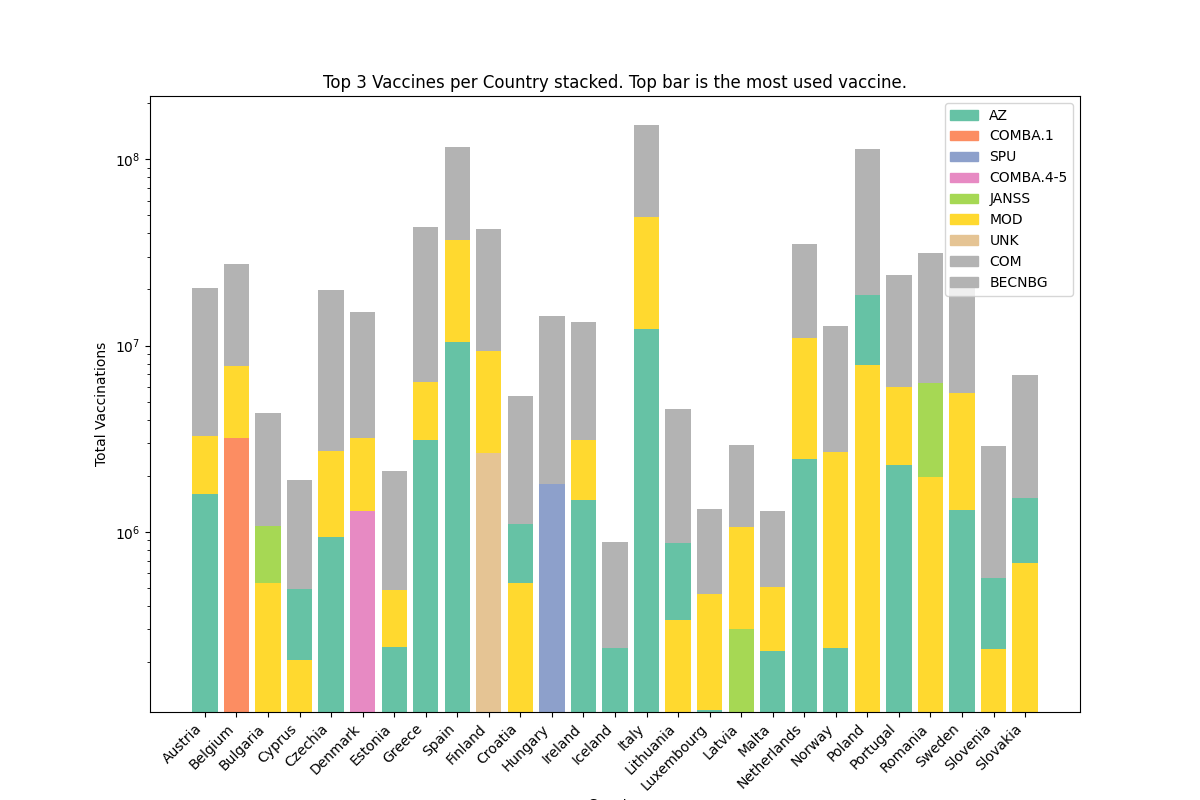

In [16]:
filtered_df = vaccination_df[(vaccination_df['Vaccine'] != 'ALL') & (vaccination_df['TargetGroup'] != 'ALL')]
vaccination_count_per_country = filtered_df.groupby(["ReportingCountry", "Vaccine"]).sum()
vaccination_count_per_country['TotalVaccinations'] = vaccination_count_per_country[['FirstDose', 'SecondDose', 'DoseAdditional1', 'DoseAdditional2', 'DoseAdditional3', 'DoseAdditional4', 'DoseAdditional5', 'UnknownDose']].sum(axis=1)
# display(vaccination_count_per_country)

summary_data = vaccination_count_per_country.groupby(['ReportingCountry','Vaccine'])['TotalVaccinations'].sum().reset_index()
total_vaccine_data_sum = summary_data.groupby(['Vaccine'])['TotalVaccinations'].sum().reset_index().sort_values(by=['TotalVaccinations'], ascending=False)
top_3_vaccines_total = total_vaccine_data_sum.nlargest(3, 'TotalVaccinations')
sorted_summary_data = summary_data.sort_values(by=['ReportingCountry','TotalVaccinations'], ascending=[True, False])
top_3_vaccines_per_country = sorted_summary_data.groupby(['ReportingCountry']).head(3)
# display(top_3_vaccines_per_country)

new_cases_df_names = new_cases_df[["geoId","countriesAndTerritories"]].drop_duplicates() #Gets all names for ReportingCountry tag
# Merge the dataframes based on 'geoId' and 'ReportingCountry'
merged_df = top_3_vaccines_per_country.merge(new_cases_df_names, 
                                            left_on=['ReportingCountry'], 
                                            right_on=['geoId'], 
                                            how='inner')





# vaccination_grouped_merged =  vaccination_grouped.merge(new_cases_df_names, left_on="ReportingCountry", right_on="geoId", how="inner").drop(columns=["geoId"])
merged_df = merged_df.drop(columns=["geoId"])

# Display the updated merged_df
# display(merged_df)
# Rename the new column
merged_df.rename(columns={'countriesAndTerritories': 'CountryName'}, inplace=True)
top_3_countries_with_name = merged_df.groupby(["ReportingCountry", "Vaccine"]).sum()


# display(merged_df) 
country_nested_list = []
for country in merged_df['CountryName'].unique():
    nested_list = []
    country_data = merged_df[merged_df['CountryName'] == country]
    nested_list = country_data.values.tolist()
    country_nested_list.append(nested_list)

# print(country_nested_list)

x_values = []
y_values = []
legend_values = []


for nested_list in country_nested_list:
    if len(nested_list) >= 3:
        x_values.append(nested_list[0][3])
        y_values.append([nested_list[0][2], nested_list[1][2], nested_list[2][2]])
        legend_values.extend([nested_list[0][1], nested_list[1][1], nested_list[2][1]])
# print(country_nested_list)

indices = np.arange(len(x_values))

# Adjust the figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Get unique legend values and their corresponding colors
unique_legend_values = list(set(legend_values))
colors = plt.cm.get_cmap('Set2', len(unique_legend_values))

# Reverse the order of y_values
y_values = [y[::-1] for y in y_values]

# Plot the stacked bars with the corresponding colors
bottom = np.zeros_like(indices)
for i, y_vals in enumerate(y_values):
    for j, y_val in enumerate(y_vals):
        ax.bar(indices[i], y_val, bottom=bottom[i], color=colors(unique_legend_values.index(legend_values[(i*3)+(2-j)])))
        bottom[i] += y_val

ax.set_yscale('log')
ax.set_xticks(indices)
ax.set_xticklabels(x_values, rotation=45, ha='right')
ax.set_xlabel('Country')
ax.set_ylabel('Total Vaccinations')
ax.set_title('Top 3 Vaccines per Country stacked. Top bar is the most used vaccine.')

# Create a dictionary for legend labels
legend_labels = {value: value for value in unique_legend_values}

# Create a custom legend with unique labels and corresponding colors
custom_legend = []
for val in unique_legend_values:
    if val in legend_labels:
        custom_legend.append(plt.Rectangle((0, 0), 1, 1, color=colors(unique_legend_values.index(val))))
        del legend_labels[val]

ax.legend(custom_legend, unique_legend_values)

# Show the plot
plt.show()

# Q4
Considering the previous question, which targets groups mainly received
these vaccine brands in each country?

In [17]:
# Filter out the 'ALL' values in the vaccine and TargetGroup columns
filtered_df = vaccination_df[(vaccination_df['Vaccine'] != 'ALL') & (vaccination_df['TargetGroup'] != 'ALL')]

# Group the filtered data by country, vaccine, and TargetGroup, and sum the dose counts
grouped_df = filtered_df.groupby(['ReportingCountry', 'Vaccine', 'TargetGroup']).sum()

# Add a new column "DosesInTotal" that sums the dose counts for each row
grouped_df['DosesInTotal'] = grouped_df[['FirstDose', 'SecondDose', 'DoseAdditional1', 'DoseAdditional2', 'DoseAdditional3', 'DoseAdditional4', 'DoseAdditional5', 'UnknownDose']].sum(axis=1)

# Reset the index to make the grouped columns accessible
grouped_df = grouped_df.reset_index()

# Get the row index for the maximum DosesInTotal value for each country and vaccine
max_dose_idx = grouped_df.groupby(['ReportingCountry', 'Vaccine'])['DosesInTotal'].idxmax()

# Create a new DataFrame with the vaccine name, country, and the highest received TargetGroup
result_df = grouped_df.loc[max_dose_idx, ['ReportingCountry', 'Vaccine', 'TargetGroup']]

# Display the result DataFrame
# display(result_df)


# Merge the "top_3_vaccines_per_country" DataFrame with the "result_df" DataFrame on ReportingCountry and Vaccine columns
merged_df = pd.merge(top_3_countries_with_name, result_df, on=['ReportingCountry', 'Vaccine'], how='left')

# Rename the TargetGroup column from result_df to MostReceivedTargetGroup
merged_df.rename(columns={'TargetGroup': 'MostReceivedTargetGroup'}, inplace=True)

final_merge = merged_df.merge(new_cases_df_names, 
                                               left_on=['ReportingCountry'], 
                                               right_on=['geoId'], 
                                               how='inner')


final_merge = final_merge.drop(columns=["geoId"])
# vaccination_grouped_merged =  vaccination_grouped.merge(new_cases_df_names, left_on="ReportingCountry", right_on="geoId", how="inner").drop(columns=["geoId"])

# Rename the new column
final_merge.rename(columns={'countriesAndTerritories': 'CountryName'}, inplace=True)

# Display the updated DataFrame
display(final_merge)

C:\Users\tobbe\AppData\Local\Temp\ipykernel_19560\472594138.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = filtered_df.groupby(['ReportingCountry', 'Vaccine', 'TargetGroup']).sum()


,ReportingCountry,Vaccine,TotalVaccinations,MostReceivedTargetGroup,CountryName
0,AT,AZ,1594060,Age25_49,Austria
1,AT,COM,17047788,Age25_49,Austria
2,AT,MOD,1656723,Age25_49,Austria
3,BE,COM,19625566,Age25_49,Belgium
4,BE,COMBA.1,3199326,Age60_69,Belgium
...,...,...,...,...,...
78,SI,COM,2310019,Age25_49,Slovenia
79,SI,MOD,236104,Age70_79,Slovenia
80,SK,AZ,844232,Age25_49,Slovakia
81,SK,COM,5462613,Age25_49,Slovakia


# Q5 
Which countries are the most skeptical towards the first dose of the COVID-19 vaccine? Do you think this matter had any impact on the hospitalization level

H0: There is no correlation between how sceptic a country in and thire hospitalization levels.  
H1: There is a correlation between how sceptic a country in and thire hospitalization levels.

P-value: 0.190101925239652  
Correlation coefficient: 0.3580248454406074  
Answer: There is no correlation between how sceptic a country in and thire hospitalization levels

Correlation coefficient: 0.3580248454406074
p-value: 0.190101925239652


Can not reject null hypothesis. There is no significant correlation.


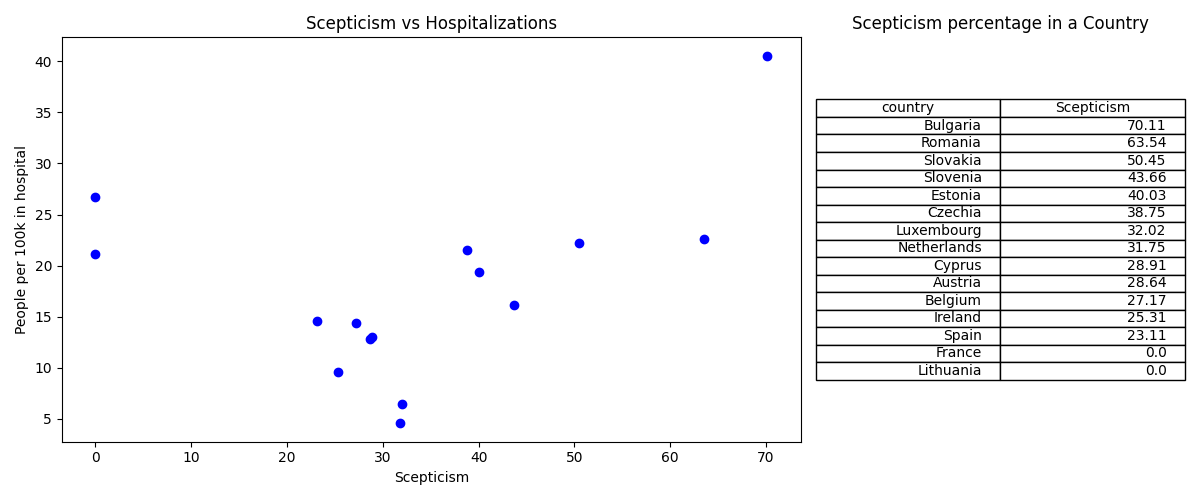

In [73]:
#Taking out two dataframes to be able to merge datasets togheter later on
new_cases_df_names = new_cases_df[["geoId","countriesAndTerritories"]].drop_duplicates() #Gets all names for ReportingCountry tag
get_population = new_cases_df[["countriesAndTerritories","popData2020"]].drop_duplicates() #Gets all population data for each country

#Copies the icu_df dataframe
hospital_level = icu_df.copy()

#Choosing the daily occupancy and icu occupancy since they are the ones that show how much people are in hospitals and then summing them together for each day
healthcare = hospital_level[hospital_level["indicator"].isin(["Daily hospital occupancy", "Daily ICU occupancy"])]
hospital_level["combined_occupancy"] = hospital_level.groupby(["date", "country"])["value"].transform(sum)
hospital_level = hospital_level[hospital_level["indicator"] == "Daily hospital occupancy"]

#Merging the hospital levels and population data togheter and then calculating the people per 100k
hospital_level =  hospital_level.merge(get_population, left_on="country", right_on="countriesAndTerritories", how="inner").drop(columns="countriesAndTerritories")
hospital_level["people_per_100k"] = hospital_level["value"]/hospital_level["popData2020"]*100000
hospital_level = hospital_level.groupby(["country", "year_week"]).agg({"people_per_100k": "mean"}).reset_index()

#begining to calculate Sceptisem score for each country using the ALL vaccines data
vaccination_grouped = vaccination_df[vaccination_df["TargetGroup"]=="ALL"]

#Calculating how many doses are left for first dose, this is too see if a country are in vaccin deficet or not, if they are in deficit they cant be sceptical since they dont even have enough doses
vaccination_grouped = vaccination_grouped.groupby(["ReportingCountry", "YearWeekISO"])[["ReportingCountry","YearWeekISO","NumberDosesReceived",'FirstDose', 'SecondDose', 'DoseAdditional1', 'DoseAdditional2', 'DoseAdditional3', 'DoseAdditional4', 'DoseAdditional5', 'UnknownDose', "Population"]].agg({"NumberDosesReceived": "sum", "FirstDose": "sum","SecondDose":"sum","DoseAdditional1":"sum","DoseAdditional2":"sum","DoseAdditional3":"sum","DoseAdditional4":"sum","DoseAdditional5":"sum","UnknownDose":"sum","Population":"first"}).reset_index() #Groups by country and week and sums the doses and takes the first population value
vaccination_grouped["Vaccinations_left_for_first"] = vaccination_grouped["NumberDosesReceived"]-vaccination_grouped["SecondDose"]-vaccination_grouped["DoseAdditional1"]-vaccination_grouped["DoseAdditional2"]-vaccination_grouped["DoseAdditional3"]-vaccination_grouped["DoseAdditional4"]-vaccination_grouped["DoseAdditional5"]-vaccination_grouped["UnknownDose"] #Calculates the number of vaccinations left for first dose
vaccination_grouped  = vaccination_grouped.drop(columns=["SecondDose","DoseAdditional1","DoseAdditional2","DoseAdditional3","DoseAdditional4","DoseAdditional5","UnknownDose"]) #Drops the columns that are not needed anymore

#Merges the vaccination data with the new cases data to get the countries names to be able to merge with icu data, we are using this dataframe as a linking method since it has both country name and tag
vaccination_grouped_merged =  vaccination_grouped.merge(new_cases_df_names, left_on="ReportingCountry", right_on="geoId", how="inner").drop(columns=["geoId"])

#Merging data with hospital data to get hospitalazion values for each week and country and calcu
vaccination_grouped_merged_hospital =  vaccination_grouped_merged.merge(hospital_level, left_on=["countriesAndTerritories","YearWeekISO"], right_on=["country","year_week"], how="inner").drop(columns=["year_week","countriesAndTerritories"])
vaccination_grouped_merged_hospital = vaccination_grouped_merged_hospital.groupby("country").agg({"NumberDosesReceived": "sum", "FirstDose": "sum","Vaccinations_left_for_first":"sum","Population":"first","people_per_100k": "mean"}).reset_index() #Groups by country and week and sums the doses and tekes the first population va


#Cheking if the number of vaccinations left for first dose is negative and if it is then there is a shortage of vaccines and we cant know if the country is sceptic or just dont have vaccine
for index, row in vaccination_grouped_merged_hospital.iterrows():
    if row['Vaccinations_left_for_first'] < 0:
        vaccination_grouped_merged_hospital.loc[index, "Shortage of vaccine"] = "Yes"
    else:
        vaccination_grouped_merged_hospital.loc[index, "Shortage of vaccine"] = "No"

#removing the countries with shortage of vaccines
vaccinations_no_shortage = vaccination_grouped_merged_hospital[vaccination_grouped_merged_hospital["Shortage of vaccine"]=="No"]

#calculating a scepticism value for each country in percentage
vaccinations_no_shortage["Scepticism"] = round((1-(vaccinations_no_shortage["FirstDose"]/vaccinations_no_shortage["Population"]))*100,2)

#removing the countries with negative scepticism since these countries are not sceptic at all
for index, row in vaccinations_no_shortage.iterrows():
    if row['Scepticism'] < 0:
        vaccinations_no_shortage.at[index, "Scepticism"] = 0


#Creating a figure for plotting
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1]})


#Setting labels and title
ax.set_title("Scepticism vs Hospitalizations")
ax.set_xlabel("Scepticism")
ax.set_ylabel("People per 100k in hospital")
ax.scatter(vaccinations_no_shortage["Scepticism"],vaccinations_no_shortage["people_per_100k"], color="blue")

####################################################Plot table####################################################
#Crating a table for the scepticism values
ax2.axis('off')
ax2.axis('tight')
ax2.set_title("Scepticism percentage in a Country")

table_content = vaccinations_no_shortage[["country","Scepticism"]].sort_values(by="Scepticism", ascending=False).reset_index(drop=True)

ax2.table(cellText=table_content.values, colLabels=table_content.columns, loc='center')
fig.tight_layout()


#calculating the correlation and p-value with R-pearson
correlation, p_value = pearsonr(vaccinations_no_shortage['Scepticism'], vaccinations_no_shortage['people_per_100k'])

#Printing the correlation and p-value
print('Correlation coefficient:', correlation)
print('p-value:', p_value)
print("\n")

alpha = 0.05  # significance level

#H0 assumes no correlation between skepticism and value, while the alternative hypothesis H1 assumes a correlation exists.
if p_value < alpha:
    print('Rejected the null hypothesis. There is a significant correlation.')
else:
    print('Can not reject null hypothesis. There is no significant correlation.')

Croatia,Denmark,Finland,Lichtenstein,Poland Countirs that is missing in icu dataset


# Q6
Rank all EU/EEA countries, based on their vaccinated population under
age 18 for the first dose of the COVID-19 vaccine, which countries have
the most and least vaccinated people under age 18 in regards to their total
populations?

<BarContainer object of 29 artists>

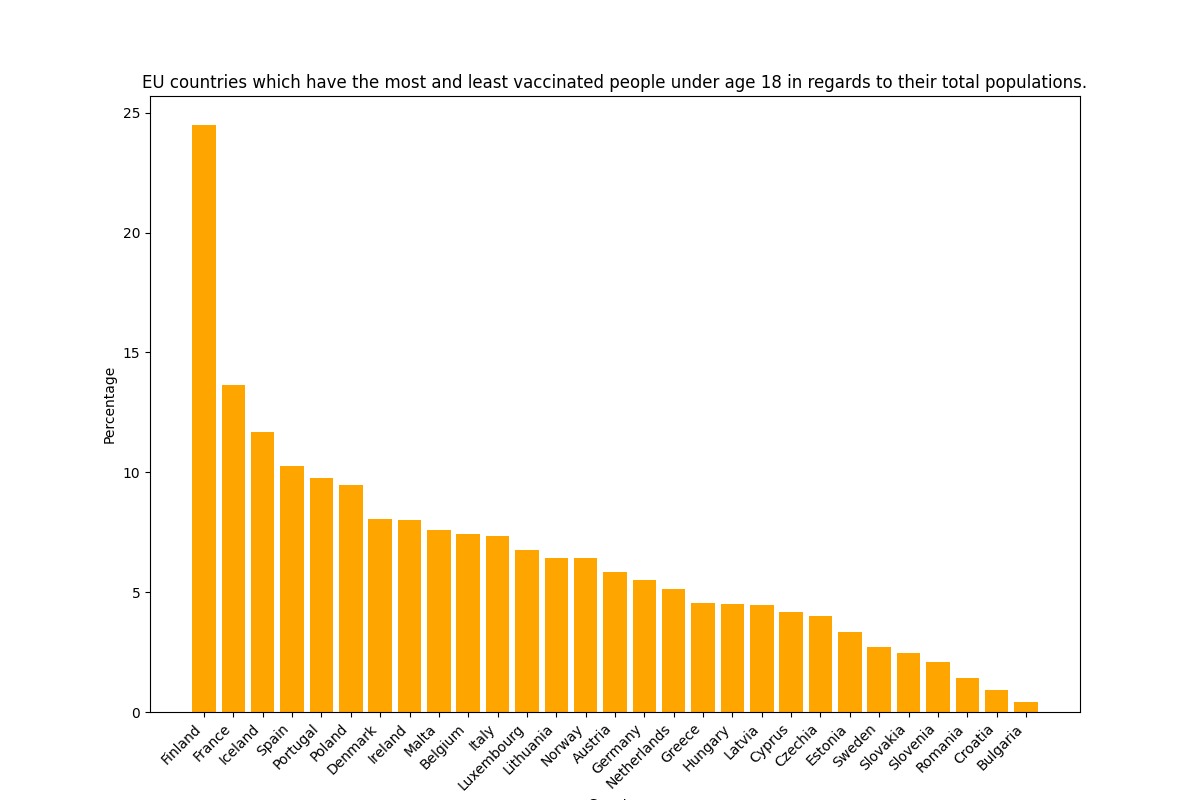

In [19]:
new_df = vaccination_df[['ReportingCountry', 'FirstDose', 'TargetGroup', 'Population']]
# Define the age group values to filter



new_cases_df_names = new_cases_df[["geoId","countriesAndTerritories"]].drop_duplicates() #Gets all names for ReportingCountry tag
# Merge the dataframes based on 'geoId' and 'ReportingCountry'
merged_df = new_df.merge(new_cases_df_names, 
                                            left_on=['ReportingCountry'], 
                                            right_on=['geoId'], 
                                            how='inner')



# vaccination_grouped_merged =  vaccination_grouped.merge(new_cases_df_names, left_on="ReportingCountry", right_on="geoId", how="inner").drop(columns=["geoId"])
merged_df = merged_df.drop(columns=["geoId"])

# Rename the TargetGroup column from result_df to MostReceivedTargetGroup
merged_df.rename(columns={'countriesAndTerritories': 'CountryName'}, inplace=True)
merged_df = merged_df.drop(columns=["ReportingCountry"])
# display(merged_df)
grouped_df = merged_df.groupby('CountryName')

result = []
for country, group in grouped_df:
    # print(country)
    if group['TargetGroup'].isin(['Age<18']).any():
        age_group_values = ['Age<18']
    else:
        age_group_values = ['Age10_14', 'Age15_17', 'Age5_9', 'Age0_4']

    # Filter the DataFrame based on the age group values
    filtered_group = group[group['TargetGroup'].isin(age_group_values)]
    # print(filtered_group)

    first_dose_sum = filtered_group['FirstDose'].sum()
    equ = (first_dose_sum / filtered_group['Population'].iloc[0]) * 100
       
    # Add country and age group to the result list
    result.append([country, equ])

sorted_list = sorted(result, key=lambda x: x[1], reverse=True)
# print(sorted_list)
x_values = [item[0] for item in sorted_list]

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xticks(range(len(x_values)))
ax.set_xticklabels(x_values, rotation=45, ha='right')
ax.set_xlabel('Country')
ax.set_ylabel('Percentage')
ax.set_title('EU countries which have the most and least vaccinated people under age 18 in regards to their total populations.')
plt.bar([x[0] for x in sorted_list], [x[1] for x in sorted_list], color='orange')



# Q7
Which countries have the oldest vaccinated population for the second
dose of the COVID-19 vaccine in regards to their total population?

<BarContainer object of 29 artists>

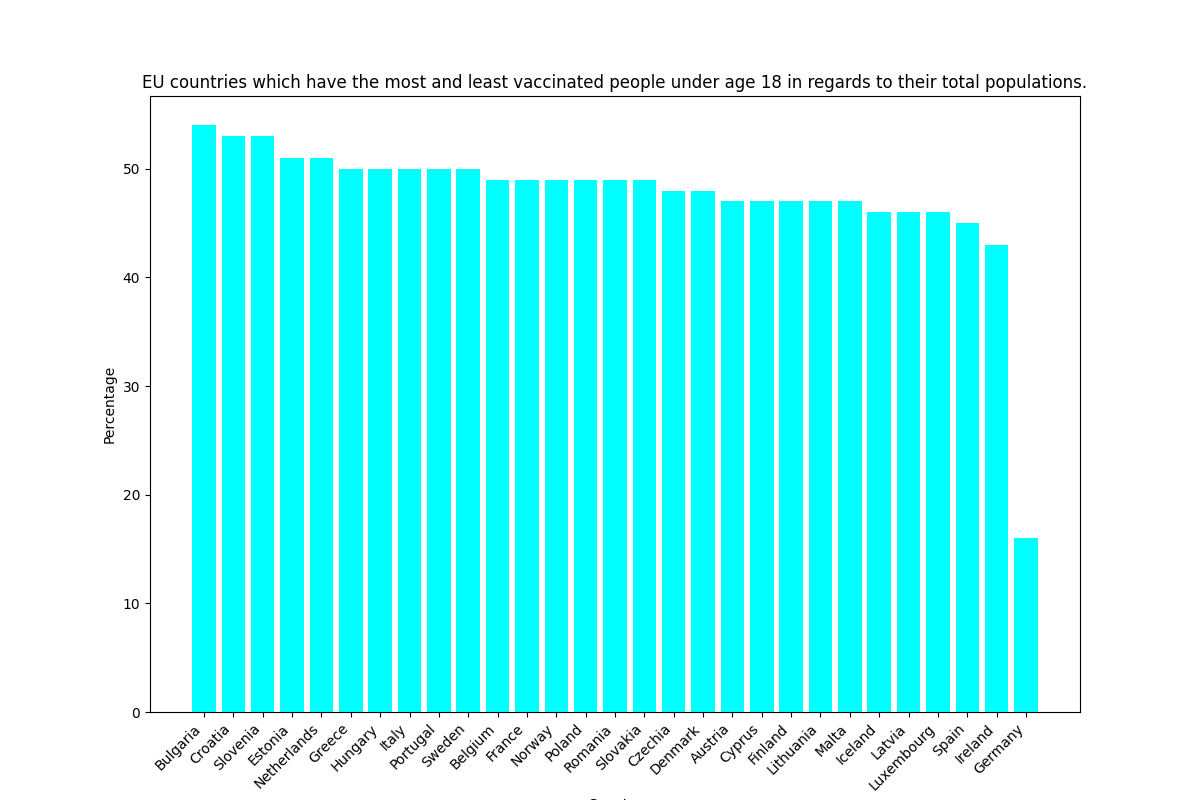

In [20]:
new_df = vaccination_df[['ReportingCountry', 'SecondDose', 'TargetGroup']]
filtered_df = new_df[new_df['TargetGroup'].str.startswith('Age')]
filtered_df = filtered_df[filtered_df['TargetGroup'] != 'AgeUNK']

new_cases_df_names = new_cases_df[["geoId","countriesAndTerritories"]].drop_duplicates() #Gets all names for ReportingCountry tag
# Merge the dataframes based on 'geoId' and 'ReportingCountry'
merged_df = filtered_df.merge(new_cases_df_names, 
                                            left_on=['ReportingCountry'], 
                                            right_on=['geoId'], 
                                            how='inner')





merged_df = merged_df.drop(columns=["geoId"])

# Rename the TargetGroup column from result_df to MostReceivedTargetGroup
merged_df.rename(columns={'countriesAndTerritories': 'CountryName'}, inplace=True)
merged_df = merged_df.drop(columns=["ReportingCountry"])


filtered_df = merged_df[merged_df['TargetGroup'] != 'ALL']


# Get the unique values in the 'TargetGroup' column
# target_group_values = filtered_df['TargetGroup'].unique()

# # Print the unique values
# for value in target_group_values:
#     print(value)

age_group_mapping = {
    'Age0_4': 2,
    'Age5_9': 7,
    'Age10_14': 12,
    'Age15_17': 16,
    'Age<18': 16,
    'Age18_24': 23,
    'Age25_49': 37,
    '1_Age<60': 40, 
    'Age50_59': 55,
    'Age60_69': 65,
    'Age70_79': 75,
    '1_Age60+': 70, 
    'Age80+': 90
}

for key, value in age_group_mapping.items():
    filtered_df.loc[filtered_df['TargetGroup'] == key, 'TargetGroup'] = value

# Group the DataFrame by 'CountryName'
grouped_df = filtered_df.groupby('CountryName')

result = []
# display(filtered_df)

for country, group in grouped_df:
    # Calculate the sum of 'SecondDose' and 'TargetGroup' multiplied values
    total_product = (group['SecondDose'] * group['TargetGroup']).sum()
    second_dose_sum = group['SecondDose'].sum()
    
    # Calculate the ratio
    ratio = total_product / second_dose_sum
    
    # Round the result
    rounded_result = round(ratio)
    
    # Add country and age group to the result list
    result.append([country, rounded_result])


sorted_list = sorted(result, key=lambda x: x[1], reverse=True)



x_values = [item[0] for item in sorted_list]

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xticks(range(len(x_values)))
ax.set_xticklabels(x_values, rotation=45, ha='right')
ax.set_xlabel('Country')
ax.set_ylabel('Percentage')
ax.set_title('EU countries which have the most and least vaccinated people under age 18 in regards to their total populations.')
plt.bar([x[0] for x in sorted_list], [x[1] for x in sorted_list], color='cyan')


# Q8 
Which countries’ health care was most affected by the coronavirus pandemic in 2020 compared to others? How are these statistics in 2022?

C:\Users\tobbe\AppData\Local\Temp\ipykernel_19560\3380918770.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  healthcare= healthcare.groupby(["country","year_week"]).mean().reset_index()
C:\Users\tobbe\AppData\Local\Temp\ipykernel_19560\3380918770.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  healthcare2022_mean = healthcare2022.mean().sort_values("people_per_100k", ascending=False).reset_index()
C:\Users\tobbe\AppData\Local\Temp\ipykernel_19560\3380918770.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default

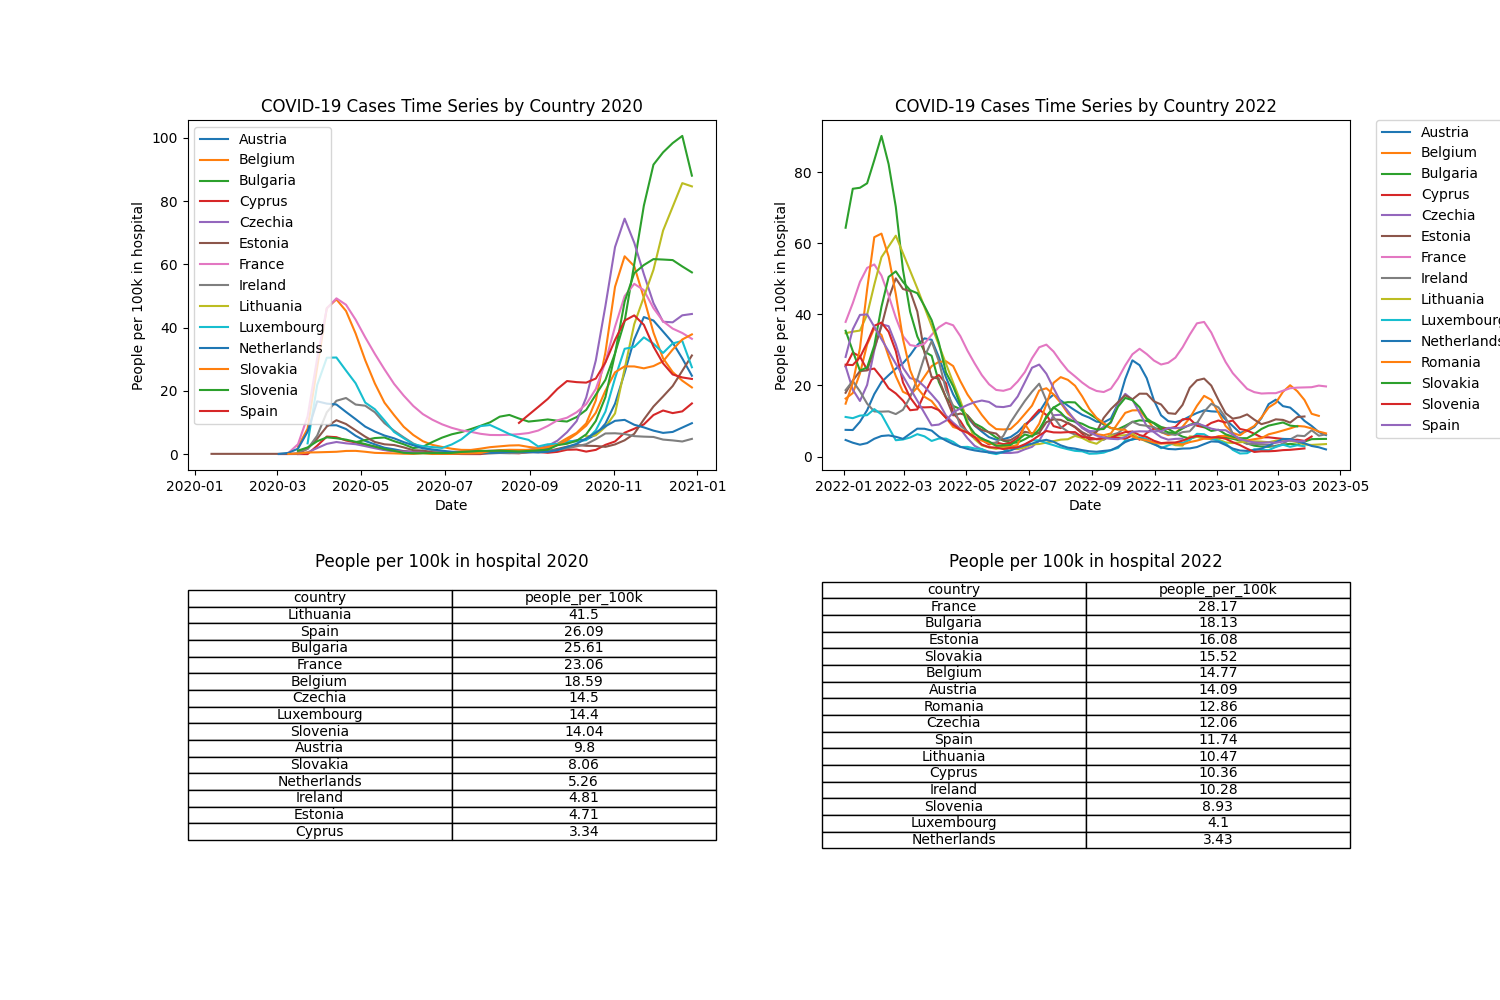

In [78]:
# Create a figure and an array of subplots
fig,axes = plt.subplots(2,2, figsize=(15,10)) 
ax = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

#copying the dataframe to not change to much in it
healthcare = icu_df.copy()

#Getting only the pupulation and country name to get population to the icu_df
get_population = new_cases_df[["countriesAndTerritories","popData2020"]].drop_duplicates()

#Choosing the daily occupancy and icu occupancy since they are the ones that show how much people are in hospitals and then summing them together for each day
healthcare = healthcare[healthcare["indicator"].isin(["Daily hospital occupancy", "Daily ICU occupancy"])]
healthcare["combined_occupancy"] = healthcare.groupby(["date", "country"])["value"].transform(sum)

#Getting the mean of the combined occupancy for each country for each week since all countries dont have data for each day
healthcare = healthcare[healthcare["indicator"] == "Daily hospital occupancy"]
healthcare= healthcare.groupby(["country","year_week"]).mean().reset_index()

#Merging the population data with the healthcare data to get the population to the icu dataset
healthcare =  healthcare.merge(get_population, left_on="country", right_on="countriesAndTerritories", how="inner").drop(columns="countriesAndTerritories")

#calculating how many people are in the hospital per 100k people
healthcare["people_per_100k"] = healthcare["value"]/healthcare["popData2020"]*100000

#Getting the data for 2022 and 2020 to be able to plot and compare the data
healthcare2022 = healthcare[healthcare["year_week"] >= "2022-01-01"]
healthcare2022 = healthcare2022.groupby("country")
healthcare2022_mean = healthcare2022.mean().sort_values("people_per_100k", ascending=False).reset_index()

healthcare2020 = healthcare[healthcare["year_week"] < "2021-01-01"]
healthcare2020 = healthcare2020.groupby("country")
healthcare2020_mean = healthcare2020.mean().sort_values("people_per_100k", ascending=False).reset_index()

#Plotting the data for both years
for country, data in healthcare2020:
    ax.plot(data["year_week"], data["people_per_100k"], label=country)

for country, data in healthcare2022:
    ax2.plot(data["year_week"], data["people_per_100k"], label=country)

#Setting labesl and titles for the plots
ax.set_xlabel("Date")
ax.set_ylabel("People per 100k in hospital")
ax.set_title("COVID-19 Cases Time Series by Country 2020")
ax.legend()

ax2.set_xlabel("Date")
ax2.set_ylabel("People per 100k in hospital")
ax2.set_title("COVID-19 Cases Time Series by Country 2022")
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

####################################################Plot table####################################################
#Crating a table for the data of 2020 where country and people in hospitals per 100k are shown
ax3.axis('off')
ax3.axis('tight')
ax3.set_title("People per 100k in hospital 2020", y=0.9)

table_content = healthcare2020_mean[["country","people_per_100k"]].sort_values(by="people_per_100k", ascending=False).reset_index(drop=True) # Create a dataframe with the data to display sorted on cases
table_content['people_per_100k'] = table_content['people_per_100k'].apply(lambda x: round(x,2)) # Format the data

ax3.table(cellText=table_content.values, colLabels=table_content.columns, loc='center', cellLoc='center')


####################################################Plot table ####################################################
#Crating a table for the data of 2022 where country and people in hospitals per 100k are shown
ax4.axis('off')
ax4.axis('tight')
ax4.set_title("People per 100k in hospital 2022", y=0.9)

table_content2 = healthcare2022_mean[["country","people_per_100k"]].sort_values(by="people_per_100k", ascending=False).reset_index(drop=True) # Create a dataframe with the data to display sorted on cases
table_content2['people_per_100k'] = table_content2['people_per_100k'].apply(lambda x: round(x,2)) # Format the data

ax4.table(cellText=table_content2.values, colLabels=table_content2.columns, loc='center', cellLoc='center')

# Show the plot
plt.show()
